## Mitigatin the Fairness Issues using Pre-Processing: Removing Bais from Data

We can use the `CorrelationRemover` function in `Fairlearn` package for this purpose. It removes sensitive features from data and regresses out the sensitive features from non-sensitive features and uses the residuals as corrected features for bias.



In [2]:
pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 1.5 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install --upgrade numexpr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.0/405.0 kB 1.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: numexpr
    Found existing installation: numexpr 2.7.3
    Uninstalling numexpr-2.7.3:
      Successfully uninstalled numexpr-2.7.3


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
import seaborn as sns
from fairlearn.preprocessing import CorrelationRemover

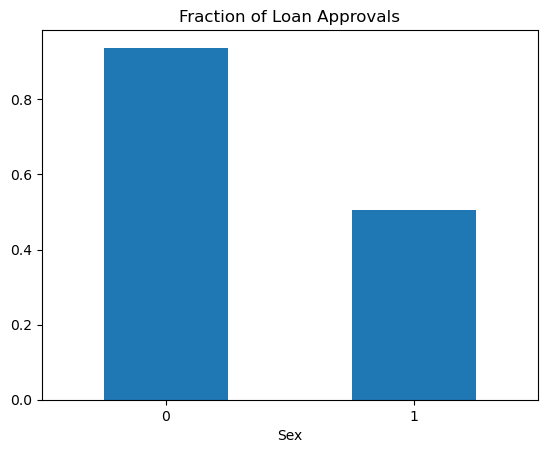

In [2]:
# Generate synthetic data
np.random.seed(42)
n = 1000

# Generate synthetic features:
# - Credit score (normally around 300-850)
# - Annual income in thousands (normally around mean of $50k with std dev of $15k)
# - Employment history in years (normally around 0-40)
X = pd.DataFrame({
    'Credit_Score': np.random.normal(650, 100, n),
    'Annual_Income_k': np.random.normal(50, 15, n),
    'Employment_History_y': np.random.normal(20, 10, n),
    'Interest_Rate': np.random.normal(5, 1, n),
    'Sex': np.random.choice([0, 1], n)  # 0 for 'Male', 1 for 'Female'
})

# Introduce a bias in the 'Interest_Rate' feature based on the sensitive attribute 'Sex'
X.loc[X['Sex'] == 1, 'Interest_Rate'] += 2  # Females have higher interest rates on average

# Introduce a strong bias in the label (loan approval) based on the sensitive attribute (sex)
threshold_male = 1.5  # A relatively low bar for males
threshold_female = 2.0  # A higher bar for females

# Calculate a synthetic loan approval decision based on the financial features and bias

y = pd.DataFrame({'Loan_Approval':np.zeros(X.shape[0])})
y.loc[(X['Sex'] == 0) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_male), 'Loan_Approval'] = 1
y.loc[(X['Sex'] == 1) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_female), 'Loan_Approval'] = 1

selection_rates = MetricFrame(
    metrics=selection_rate, y_true=y['Loan_Approval'], y_pred=y['Loan_Approval'], sensitive_features=X['Sex']
)

fig = selection_rates.by_group.plot.bar(
    legend=False, rot=0, title="Fraction of Loan Approvals"
)

We can visualize the possible correlation between senstive and non-sensitive features using a heatmap plot of correlations.

<Axes: >

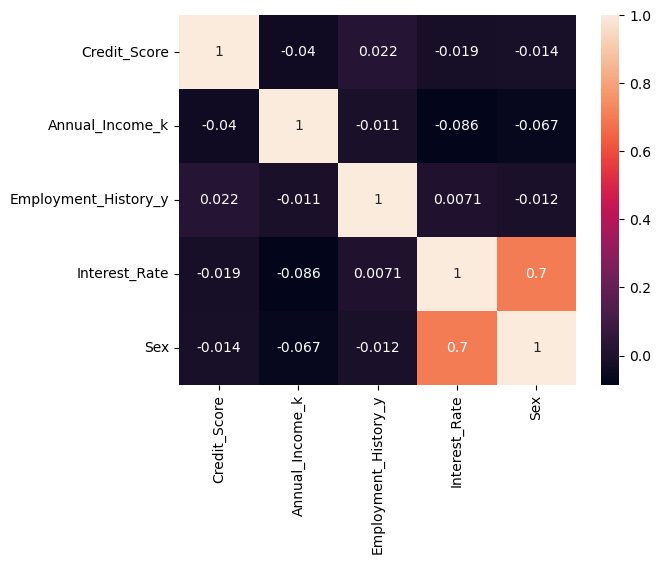

In [3]:
sns.heatmap(X.corr(), annot=True)

Then we can use the coorelartion remover to remove the bias from data. Mind that we fit it only on the training data and then transfom both training and test data.

<Axes: >

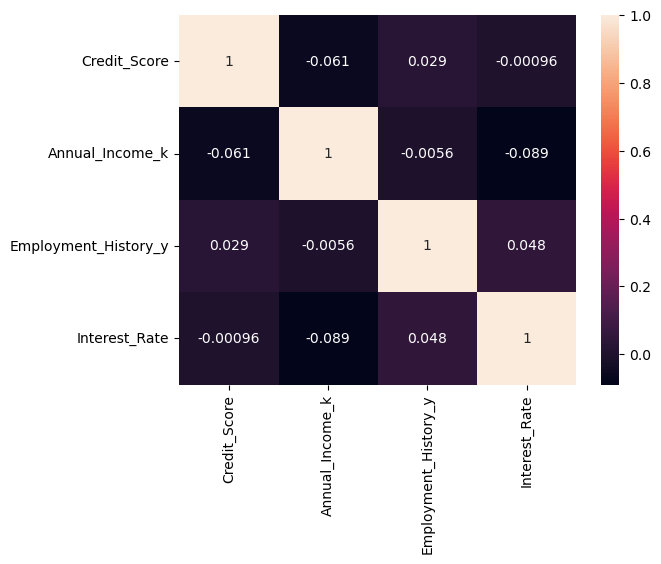

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_test = X_test['Sex']

cr = CorrelationRemover(sensitive_feature_ids=["Sex"], alpha=0.5)
X_train_cr = cr.fit_transform(X_train)
X_train_cr = pd.DataFrame(X_train_cr, columns=['Credit_Score','Annual_Income_k','Employment_History_y','Interest_Rate'])
X_test_cr = cr.transform(X_test)
X_test_cr = pd.DataFrame(X_test_cr, columns=['Credit_Score','Annual_Income_k','Employment_History_y','Interest_Rate'])

sns.heatmap(X_train_cr.corr(), annot=True)


In [5]:
# Train a Random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cr, y_train)
y_pred = clf.predict(X_test_cr)
y_pred_prob = clf.predict_proba(X_test_cr)[:,1]

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7906746031746033
AUC: 0.9170386904761906


array([[<Axes: title={'center': 'accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Sex'>,
        <Axes: xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

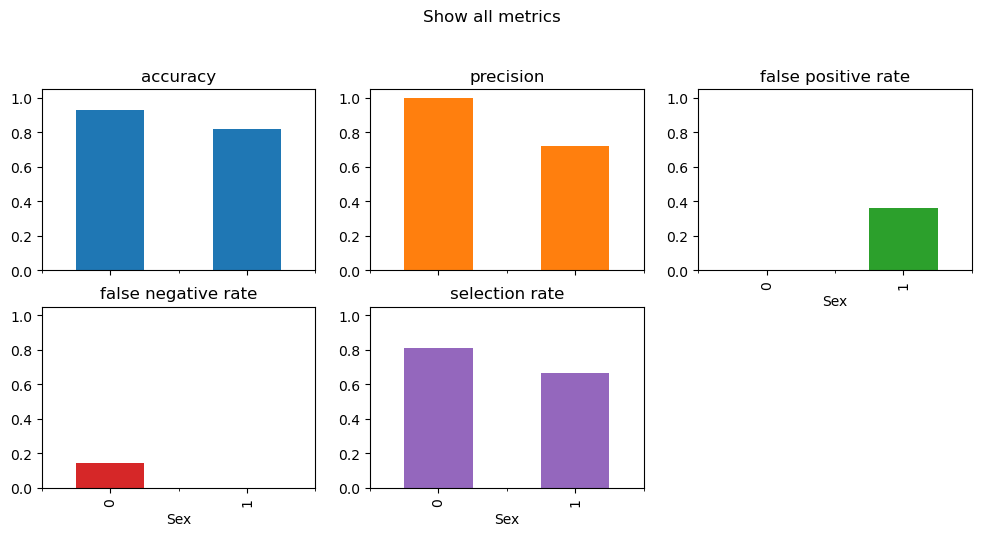

In [8]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)


In [9]:

# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.14102564102564108
Statistical Parity ratio: 0.8253968253968254
Equalized Odds Difference: 0.36
Equalized Odds Ratio: 0.0


**Exercise 4.3:** Try combining the preprocessing techniques, i.e, first resample the data and then apply the correlation remover. Report the results in comparison with two previous experiments.

Accuracy (with resampling and correlation removal): 0.8335483870967741
AUC (with resampling and correlation removal): 0.9338709677419355
Statistical Parity Difference (with resampling and correlation removal): 0.29523809523809524
Statistical Parity ratio (with resampling and correlation removal): 0.504
Equalized Odds Difference (with resampling and correlation removal): 0.21904761904761905
Equalized Odds Ratio (with resampling and correlation removal): 0.0


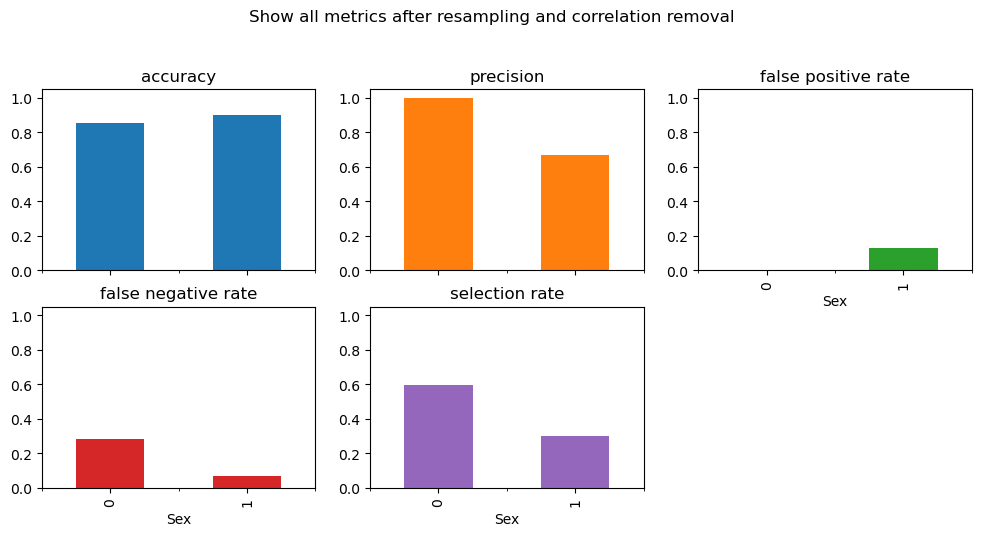

In [10]:
from sklearn.utils import resample

# Step 1: Resample the data
# Combine X and y for resampling
data = pd.concat([X, y], axis=1)

# Separate majority and minority classes
majority = data[data['Loan_Approval'] == 0]
minority = data[data['Loan_Approval'] == 1]

# Upsample minority class
minority_upsampled = resample(minority, 
                              replace=True,     # sample with replacement
                              n_samples=len(majority),    # to match majority class
                              random_state=42) # reproducible results

# Combine majority class with upsampled minority class
upsampled = pd.concat([majority, minority_upsampled])

# Separate features and labels
X_upsampled = upsampled.drop('Loan_Approval', axis=1)
y_upsampled = upsampled['Loan_Approval']

# Step 2: Split the upsampled data
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=42)
sensitive_test = X_test['Sex']

# Apply the Correlation Remover
cr = CorrelationRemover(sensitive_feature_ids=["Sex"], alpha=0.5)
X_train_cr = cr.fit_transform(X_train)
X_train_cr = pd.DataFrame(X_train_cr, columns=['Credit_Score','Annual_Income_k','Employment_History_y','Interest_Rate'])
X_test_cr = cr.transform(X_test)
X_test_cr = pd.DataFrame(X_test_cr, columns=['Credit_Score','Annual_Income_k','Employment_History_y','Interest_Rate'])

# Step 3: Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cr, y_train)
y_pred = clf.predict(X_test_cr)
y_pred_prob = clf.predict_proba(X_test_cr)[:, 1]

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy (with resampling and correlation removal): {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC (with resampling and correlation removal): {auc}")

# Step 4: Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0, 1.05],
    title="Show all metrics after resampling and correlation removal",
)

# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference (with resampling and correlation removal): {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio (with resampling and correlation removal): {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference (with resampling and correlation removal): {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio (with resampling and correlation removal): {equal_odds_rto}")


In [12]:

# Split the original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_test = X_test['Sex']

# Apply correlation removal
cr = CorrelationRemover(sensitive_feature_ids=["Sex"], alpha=0.5)
X_train_cr = cr.fit_transform(X_train)
X_train_cr = pd.DataFrame(X_train_cr, columns=['Credit_Score', 'Annual_Income_k', 'Employment_History_y', 'Interest_Rate'])
X_test_cr = cr.transform(X_test)
X_test_cr = pd.DataFrame(X_test_cr, columns=['Credit_Score', 'Annual_Income_k', 'Employment_History_y', 'Interest_Rate'])

# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cr, y_train)
y_pred = clf.predict(X_test_cr)
y_pred_prob = clf.predict_proba(X_test_cr)[:, 1]

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy (Correlation Removal Only): {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC (Correlation Removal Only): {auc}")

# Measure fairness metrics
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference (Correlation Removal Only): {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Ratio (Correlation Removal Only): {stat_parity_rto}")

equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference (Correlation Removal Only): {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio (Correlation Removal Only): {equal_odds_rto}")


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy (Correlation Removal Only): 0.7906746031746033
AUC (Correlation Removal Only): 0.9170386904761906
Statistical Parity Difference (Correlation Removal Only): 0.14102564102564108
Statistical Parity Ratio (Correlation Removal Only): 0.8253968253968254
Equalized Odds Difference (Correlation Removal Only): 0.36
Equalized Odds Ratio (Correlation Removal Only): 0.0


In [13]:
# Split the original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_test = X_test['Sex']

# Train the model on the original data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy (No Preprocessing): {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC (No Preprocessing): {auc}")

# Measure fairness metrics
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference (No Preprocessing): {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Ratio (No Preprocessing): {stat_parity_rto}")

equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference (No Preprocessing): {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio (No Preprocessing): {equal_odds_rto}")


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy (No Preprocessing): 0.9682539682539683
AUC (No Preprocessing): 0.997953869047619
Statistical Parity Difference (No Preprocessing): 0.4639423076923077
Statistical Parity Ratio (No Preprocessing): 0.5025773195876289
Equalized Odds Difference (No Preprocessing): 0.05501330967169471
Equalized Odds Ratio (No Preprocessing): 0.0


                          Metric  No Preprocessing  Correlation Removal Only  \
0                       Accuracy             0.968                     0.791   
1                            AUC             0.998                     0.917   
2  Statistical Parity Difference             0.464                     0.141   
3       Statistical Parity Ratio             0.503                     0.825   
4      Equalized Odds Difference             0.055                     0.360   
5           Equalized Odds Ratio             0.000                     0.000   

   With Resampling and Correlation Removal  
0                                    0.834  
1                                    0.934  
2                                    0.295  
3                                    0.504  
4                                    0.219  
5                                    0.000  


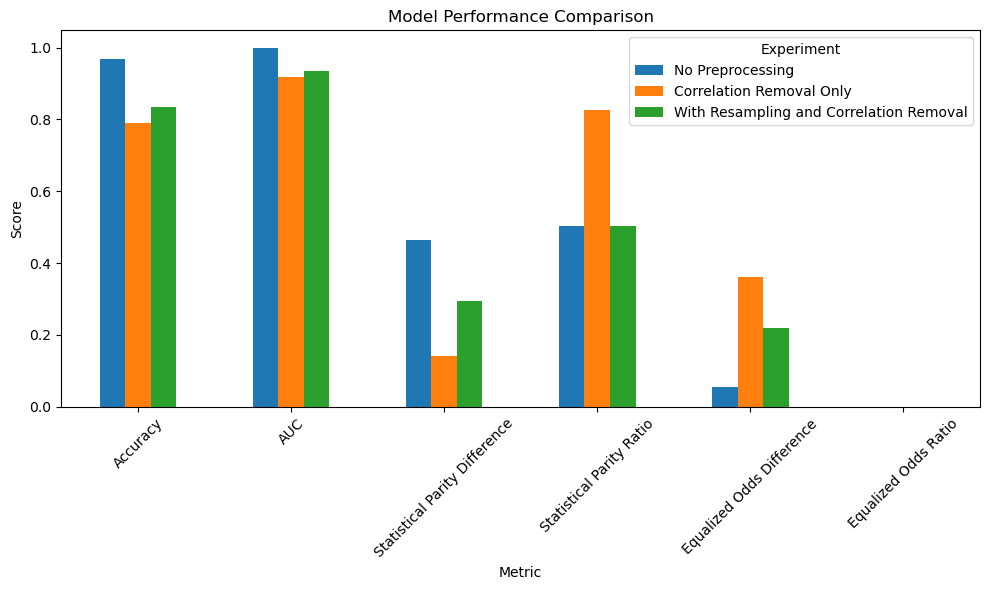

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with the results
results = {
    "Metric": [
        "Accuracy", 
        "AUC", 
        "Statistical Parity Difference", 
        "Statistical Parity Ratio", 
        "Equalized Odds Difference", 
        "Equalized Odds Ratio"
    ],
    "No Preprocessing": [
        0.968, 
        0.998, 
        0.464, 
        0.503, 
        0.055, 
        0.0
    ],
    "Correlation Removal Only": [
        0.791, 
        0.917, 
        0.141, 
        0.825, 
        0.360, 
        0.0
    ],
    "With Resampling and Correlation Removal": [
        0.834, 
        0.934, 
        0.295, 
        0.504, 
        0.219, 
        0.0
    ]
}

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display the table
print(results_df)

# Optional: Visualize the results
results_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Experiment')
plt.tight_layout()
plt.show()


In [ ]:
REPORT

No preprocessing:
Accuracy: The model predicted 96.8% of loan approvals correctly.
AUC: It had a high score of 99.8%, indicating that it was excellent at differentiating between approved and non-approved loans.
Statistical Parity Difference: There was a significant (46.4%) difference in loan acceptance rates between genders, indicating unequal treatment.
Statistical Parity Ratio: The ratio was approximately 50.3%, demonstrating some degree of fairness.
Equalized Odds Difference: The difference was minimal (5.5%), indicating that the model's predictions were very consistent across genders.


Correlation Removal Only: 
Accuracy decreased to 79.1%.
AUC: It also decreased to 91.7%, indicating that it was still good but not as great as before.
Statistical Parity Difference: The disparity has shrunk to 14.1%, which is better but still indicates some bias.
The Statistical Parity Ratio improved to 82.5%, showing greater fairness.
Equalized Odds Difference: The difference rose to 36.0%, indicating that the model was less consistent in its predictions.


With Resampling and Correlation Removal:
Accuracy: The accuracy increased to 83.4%.
AUC: It also improved, reaching 93.4%.
Statistical Parity Difference: The gap was 29.5%, indicating progress but with some bias.
Statistical Parity Ratio: The ratio of 50.4% indicates a reasonable level of fairness.
Equalized Odds Difference: This has fallen to 21.9%, demonstrating greater consistency in forecasts across genders.